# Profiteering Landlords

## TOC (based on assignment reqs)

Foreword: I think this notebook tells a decent story, but if you want to tick off the boxes, here are the 5 components the assignment listed.

1. [Identify the problem](#Identify-the-problem:-Bad-Landlords)
2. [Descriptive Statistics](#These-are-the-descriptive-statistics-and-scatterplot-for-the-two-key-variables.)
3. [Mapping](#Visualization)
4. [Analysis](#Modelling)
5. [Discussion](#Remarks-and-how-to-use-this-analysis)

In [139]:
!ls -lh 311_Service_Requests_from_2014_to_Present.csv
!wget -nc https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip
!unzip -o 'nyc_pluto_16v2 .zip'
!ls -lh BORO_zip_files_csv/

-rw-rw-r-- 1 vagrant vagrant 4.4G Oct  3 09:40 311_Service_Requests_from_2014_to_Present.csv
File ‘nyc_pluto_16v2 .zip’ already there; not retrieving.

Archive:  nyc_pluto_16v2 .zip
  inflating: BORO_zip_files_csv/BK.csv  
  inflating: BORO_zip_files_csv/BX.csv  
  inflating: BORO_zip_files_csv/MN.csv  
  inflating: BORO_zip_files_csv/PLUTODD16v2.pdf  
  inflating: BORO_zip_files_csv/Plutolay16v2.pdf  
  inflating: BORO_zip_files_csv/PlutoReadme16v2.pdf  
  inflating: BORO_zip_files_csv/QN.csv  
  inflating: BORO_zip_files_csv/SI.csv  
total 291M
-rw-rw-r-- 1 vagrant vagrant  77M Oct 28  2016 BK.csv
-rw-rw-r-- 1 vagrant vagrant  33M Oct 28  2016 BX.csv
-rw-rw-r-- 1 vagrant vagrant  17M Oct 28  2016 MN.csv
-rw-rw-r-- 1 vagrant vagrant 373K Oct 27  2016 PLUTODD16v2.pdf
-rw-rw-r-- 1 vagrant vagrant  89K Oct 27  2016 Plutolay16v2.pdf
-rw-rw-r-- 1 vagrant vagrant  50K Oct 28  2016 PlutoReadme16v2.pdf
-rw-rw-r-- 1 vagrant vagrant 119M Oct 28  2016 QN.csv
-rw-rw-r-- 1 vagrant vagrant  46M Oct

In [2]:
import pandas as pd
df = pd.read_csv("311_Service_Requests_from_2014_to_Present.csv")

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (8,17,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Identify the problem: Bad Landlords
The first NYC apartment I lived in had the gas shut off for 6+ months. Looking at the landlord's buildings, this was a theme. Maybe 7 of the landlord's ~20 buildings were in this situation. I haven't run the baseline numbers, but this is almost certainly not due to random chance (i.e. legitimate failures). More likely, the landlord's buildings were mostly rent stabilized units (as our unit was), and pushing people out faster gets those units closer to being rentable at market rate.

I'm going to do the same analysis with another complaint type - heat and hot water -  to identify potentially exploitative landlords.

### Data Cleaning
I just join up PLUTO and 311 complaints here by a concatenation of address and zipcode. This is probably really janky.

In [3]:
filtered = df[df["Complaint Type"] == "HEAT/HOT WATER"]
filtered = filtered[filtered["Descriptor"] == "ENTIRE BUILDING"]

In [4]:
import glob
fs = glob.glob("BORO_zip_files_csv/*.csv")
pluto = pd.concat(pd.read_csv(f) for f in fs)

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (18,19,21,22,23,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DtypeWarning: Columns (18,19,21,22,63,64,76) have mixed types. Specify dtype option

In [5]:
import numpy as np
pluto.dropna(inplace=True, subset=["ZipCode", "Address"])
filtered.dropna(inplace=True, subset=["Incident Address", "Incident Zip"])
pluto["ZipCode"] = pluto["ZipCode"].apply(str)
pluto["zipaddress"] = pluto[["Address", "ZipCode"]].apply(lambda x:"".join(x), axis=1)
filtered["Incident Zip"] = filtered["Incident Zip"].apply(str)
filtered["zipaddress"] = filtered[["Incident Address", "Incident Zip"]].apply(lambda x: "".join(x), axis=1)

In [6]:
merged = filtered.merge(pluto, on="zipaddress")

### Initial Exploration

#### First thing: Landlords with the /most/ complaints

In [7]:
most_complaints = merged.groupby("OwnerName").size().sort_values(ascending=False)
most_complaints.describe()

count    24909.000000
mean         7.759324
std         29.548862
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       2242.000000
dtype: float64

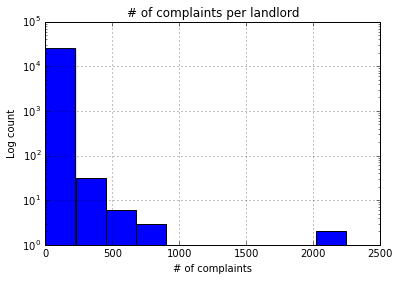

In [8]:
import matplotlib
%matplotlib inline

ax = most_complaints.hist()
ax.set_yscale("log")
ax.set_ylabel("Log count")
ax.set_xlabel("# of complaints")
ax.set_title("# of complaints per landlord")

#### Second thing: how many buildings each landlord owns

count    736692.000000
mean          1.148367
std           5.309295
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3327.000000
dtype: float64


OwnerName
PARKS AND RECREATION     3327
DCAS                     1670
HOUSING PRESERVATION     1319
NYC HOUSING AUTHORITY    1101
DCAS/DEPARTMENT OF ED    1002
OWNER / AGENT             942
DEPT OF ENVIRONMENTAL     591
NYC DEPT OF HIGHWAYS      567
HOUSING TRUST FUND CO     555
LONG ISLAND RAIL ROAD     377
NEW YORK CITY TRANSIT     265
FIRE DEPARTMENT           254
NYC DSBS                  235
POLICE DEPARTMENT         215
CNY/NYCTA                 208
CITY OF NEW YORK          194
NYC PARKS                 174
JOINTLY OWNED PLAYGRO     167
TRUSTEES OF COLUMBIA      163
THE CITY OF NEW YORK/     149
NYC DOT                   146
NYS DOT                   130
DEPT OF GENERAL SERVI     122
THE CITY OF NEW YORK      119
SANITATION                112
NEW YORK UNIVERSITY        96
FEDERAL NATIONAL MORT      94
DEUTSCHE BANK NATIONA      79
NORTHEASTERN CONFEREN      78
MHANY 2015 HOUSING DE      78
MTA - STATEN ISLAND R      75
CONSOLIDATED EDISON C      73
NEW YORK PUBLIC LIBRA      72


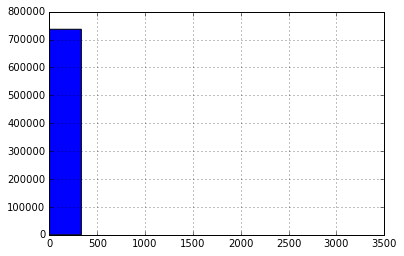

In [12]:
num_owned = pluto.groupby("OwnerName").size()
print num_owned.describe()
num_owned.hist()
num_owned.sort_values(ascending=False).head(50)

Uninteresting. Let's try dropping some of those city agencies we don't care about.

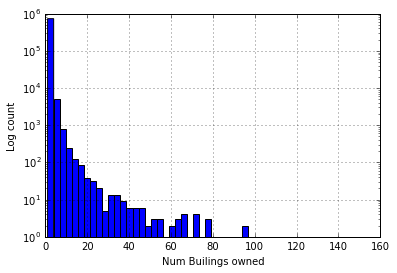

In [10]:
ax = num_owned[num_owned < 149].hist(bins=50)
ax.set_yscale("log")
ax.set_xlabel("Num Builings owned")
ax.set_ylabel("Log count")

In [11]:
num_owned[num_owned == 1].size / float(num_owned.size)

0.9204199312602824

### So we can see that really, for the most part when it comes to NYC buildings we're dealing with 1-building owners. This sort of analysis doesn't lend itself to 1-building owners. However, we can still get insight into owners of >1 and < 100 buildings. 

We might care about 1-building owners if we included a variety of other factors and saw the number of dimensions along which they were receiving complaints.

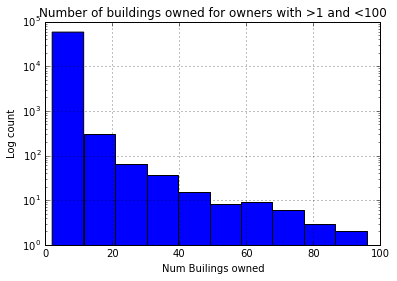

In [17]:
owns_multiple_buildings_ix = num_owned[(num_owned > 1) & (num_owned < 100)].index
owns_multiple_buildings = pluto[pluto["OwnerName"].isin(owns_multiple_buildings_ix)]
ax = owns_multiple_buildings.groupby("OwnerName").size().hist()
ax.set_title("Number of buildings owned for owners with >1 and <100")
ax.set_yscale("log")
ax.set_xlabel("Num Builings owned")
ax.set_ylabel("Log count")

This still leaves us with a good number of owners with <=20 buildings, which should be especially interesting.

In [59]:
merged = filtered.merge(owns_multiple_buildings, on="zipaddress")
len(merged)

45696

### Visualization

In [60]:
import geopandas as gpd
import shapely
complaint_counts = merged.groupby("zipaddress").size().reset_index()
complaint_counts.columns = ["zipaddress", "num_complaints"]
for item in ["num_complaints_y", "num_complaints_x", "num_complaints"]:
    try:
        merged.drop(item)
    except:
        pass
merged = merged.merge(complaint_counts, on="zipaddress")
merged["geometry"] = merged[["Latitude", "Longitude"]].apply(lambda x: shapely.geometry.Point((x[1], x[0])), axis=1)
merged = gpd.GeoDataFrame(merged)

In [36]:
!wget -nc https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson
boroughs = gpd.read_file("boroughs.geojson")

File ‘boroughs.geojson’ already there; not retrieving.



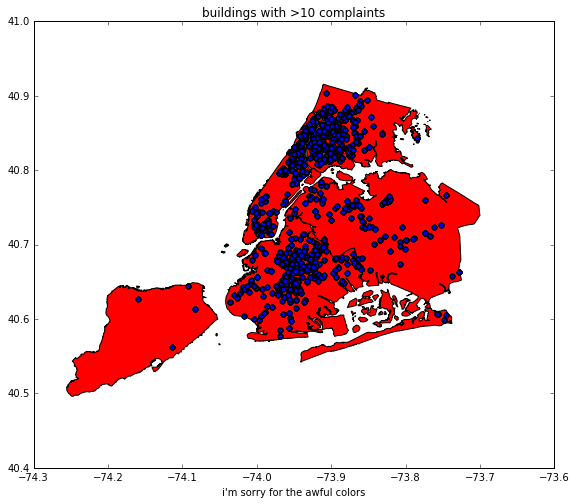

In [137]:
ax = boroughs.plot(figsize=(16, 8), color="red")
merged[merged["num_complaints"] > 10].plot(ax=ax)
ax.set_title("buildings with >10 complaints")
ax.set_xlabel("i'm sorry for the awful colors")

We can see that people complain a lot all over the city (except Staten Island). Let's look at violations, too.

1242


array([ 'The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd.',
       'The Department of Housing Preservation and Development was not able to gain access to your apartment to inspect for a lack of heat or hot water. However, HPD was able to verify that heat or hot water was inadequate by inspecting another apartment and a violation was issued. Information about specific violations is available at www.nyc.gov/hpd.',
       'The Department of Housing Preservation and Development inspected the following conditions. Violations were previously issued for these conditions. Information about specific violations is available at www.nyc.gov/hpd.'], dtype=object)

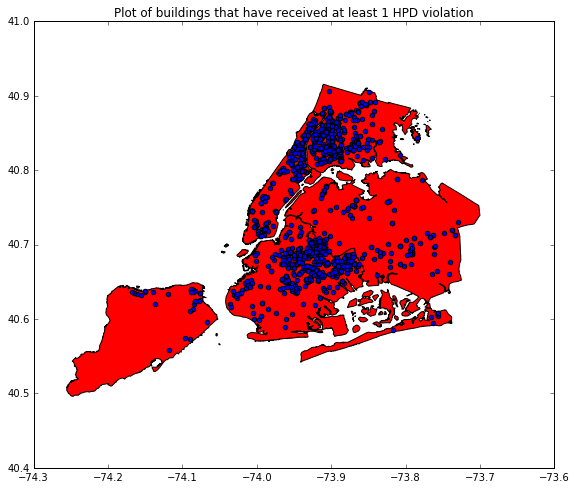

In [77]:
# this works because case sensitivity. proof in output below
strings = ["Violations were issued",
           "Violations were previously issued",
           "and a violation was issued"]
condition = (merged["Resolution Description"].str.contains(strings[0]) |\
             merged["Resolution Description"].str.contains(strings[1]) |\
             merged["Resolution Description"].str.contains(strings[2]))
bad_complaints = merged[condition]


ax = boroughs.plot(figsize=(16, 8), color='red')
ax.set_title("Plot of buildings that have received at least 1 HPD violation")
bad_complaints.plot(ax=ax)
print len(bad_complaints)
bad_complaints['Resolution Description'].unique()

We can see that these sorts of violations basically occur all over the city. But there appears to be especially high density in northeast brooklyn, upper manhattan, and the bronx.

# Analysis: count the number of buildings with at least 1 complaint owned by a particular landlord

In [39]:
num_offending_buildings = merged.groupby("zipaddress").first().reset_index().groupby("OwnerName").size().sort_values(ascending=False).to_frame()
num_offending_buildings.columns = ["# offending buildings"]

In [66]:
baseline = owns_multiple_buildings.groupby("OwnerName").size().sort_values(ascending=False).to_frame()
baseline.columns = ["# buildings owned"]

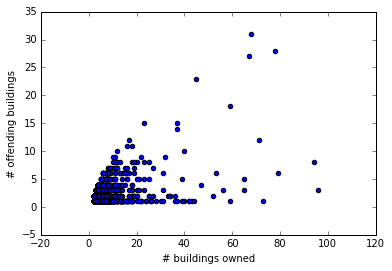

In [41]:
joined = num_offending_buildings.join(baseline)
joined['ratio'] = (joined["# offending buildings"]/joined['# buildings owned'])
joined.plot('# buildings owned', '# offending buildings', kind='scatter')

,# offending buildings,# buildings owned,ratio,bayesian_ratio
OwnerName,,,,
222-224 WEST 21ST STR,2,2,1.0,0.642857
PAUL AND NANCY ARZANI,2,2,1.0,0.642857
55-57 CLIFTON PL LLC,2,2,1.0,0.642857
WALTON AVE HOLDINGS L,2,2,1.0,0.642857
ORION REALTY LLC,2,2,1.0,0.642857


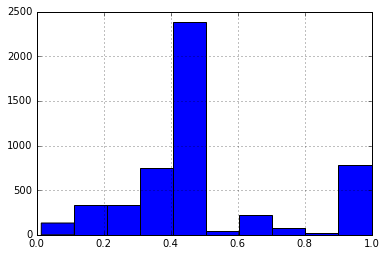

In [44]:
joined['ratio'].hist()
joined.sort_values('ratio', ascending=False).head()

As we can see, we run into a classic error: we still see many landlords owning 2 buildings and having received complaints for all 2 buildings. There are a couple of ways to deal with this

1. Bayesian smoothing - we could basically say that we expect a certain heat / hot water complaint rate and add it in as prior knowledge
2. Complaint filtering - maybe we only want to look at complaints that have certain properties.

### Bayesian Smoothing
looking at the above histogram, we can see a bimodal distribution: landlords with 2 buildings have probably received at least 1 complaint for each building (the 100% mark), whereas 50% seems like a reasonable number for other landlords. It's quite possible that landlords owning 1-2 buildings are engaging in this sort of hostile practice, but we probably can't get at it in the data here.

We'll now do the bayesian equivalent of adding 5 buildings to each landlord's count and assuming 1/2 of them have received a complaint.

In [127]:
joined['bayesian_ratio'] = (joined["# offending buildings"] + 5 * .5)/ (joined['# buildings owned'] + 5)
joined.sort_values('bayesian_ratio', ascending=False).head(50)

,# offending buildings,# buildings owned,ratio,bayesian_ratio
OwnerName,,,,
"TROY INDUSTRIES, LLC",6,6,1.000000,0.772727
UNION STREET HOUSES O,6,6,1.000000,0.772727
EAST TREMONT BRONX HO,6,6,1.000000,0.772727
"NEWSTART PROPERTIES,I",6,6,1.000000,0.772727
CYPRESS COURT ASSOCIA,6,6,1.000000,0.772727
ADONAI REALTY L.P.,6,6,1.000000,0.772727
"GVS PROPERTIES IV, LL",9,10,0.900000,0.766667
COBB REALTY LLC,5,5,1.000000,0.750000
NEIGHBORHOOD STAB ASO,5,5,1.000000,0.750000


This does a good job of pulling out owners with ~the number of buildings we'd expect who have received at least one complaint in each building. Interestingly, 430 Realty has been in at least one easily found rent control case: http://caselaw.findlaw.com/ny-civil-court/1179288.html

But, maybe a single complaint isn't the right proxy.

### Complaint Filtering
As above, let's look at complaints that actually resulted in a violation. `bad_complaints` is the name of the variable from above. 

In [48]:
bad_merged = bad_complaints.merge(owns_multiple_buildings, on="zipaddress")
bad_num_offending_buildings = bad_merged.groupby("zipaddress").first().reset_index().groupby("OwnerName_x").size().sort_values(ascending=False).to_frame()
bad_num_offending_buildings.columns = ["# offending buildings"]

In [79]:
bad_joined = bad_num_offending_buildings.join(baseline)
bad_joined['ratio'] = (bad_joined["# offending buildings"]/joined['# buildings owned'])
bad_joined.sort_values('ratio', ascending=False).head(2)

,# offending buildings,# buildings owned,ratio
OwnerName_x,,,
"NIEVES, JOAN",2,2,1.0
DESPERATION HOUSING D,2,2,1.0


In [138]:
bad_joined.sort_values("# offending buildings", ascending=False).head(5)

,# offending buildings,# buildings owned,ratio,bayesian_ratio
OwnerName_x,,,,
SILVERSHORE PROPERTIE,9,68,0.132353,0.157534
2166 DEAN LLC,5,27,0.185185,0.234375
"WELLS FARGO BANK, N.A",4,53,0.075472,0.112069
HPENY HOUSING DEVELOP,4,45,0.088889,0.130000
EAST TREMONT BRONX HO,4,6,0.666667,0.590909


In [135]:
bad_joined['bayesian_ratio'] = (bad_joined["# offending buildings"] + 5 * .5)/ (bad_joined['# buildings owned'] + 5)
bad_joined.sort_values('bayesian_ratio', ascending=False).head(25)

,# offending buildings,# buildings owned,ratio,bayesian_ratio
OwnerName_x,,,,
GIT LEB,4,4,1.00,0.722222
PENNSYLVANIA AVENUE A,3,3,1.00,0.687500
4640 BROADWAY LLC,3,3,1.00,0.687500
146-150 TENTH ASSOCIA,3,3,1.00,0.687500
"NIEVES, JOAN",2,2,1.00,0.642857
J F DAVIDSON REALTY C,2,2,1.00,0.642857
RIVLIN HOUSING ASSOCI,2,2,1.00,0.642857
AMSTERDAM 2228 LLC,2,2,1.00,0.642857
INDO-CANADIAN REALTYC,2,2,1.00,0.642857


Some similar names, but our numbers are getting small.

## Modelling
Another way to look at this is by using a linear regression. 

This takes the number of buildings owned by a landlord and attempts to set a baseline understanding for number of heat / hot water violations. We then take the largest residual values and look at those. The idea is quite similar to the above analysis. 

I used a ridge regression with alpha = 2 to penalize a large slope.

#### These are the descriptive statistics and scatterplot for the two key variables.

In [136]:
bad_joined[["# buildings owned", "# offending buildings"]].describe()

,# buildings owned,# offending buildings
count,768.000000,768.000000
mean,4.817708,1.169271
std,7.409997,0.564018
min,2.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,1.000000
75%,4.000000,1.000000
max,79.000000,9.000000


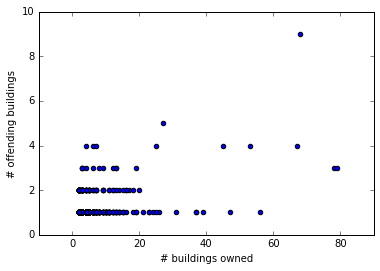

In [122]:
bad_joined.plot("# buildings owned", "# offending buildings", kind='scatter')

In [123]:
from sklearn.linear_model import Ridge
len(bad_joined["# buildings owned"])
lr = Ridge(alpha=2).fit(bad_joined["# buildings owned"].reshape(-1, 1), bad_joined["# offending buildings"])

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


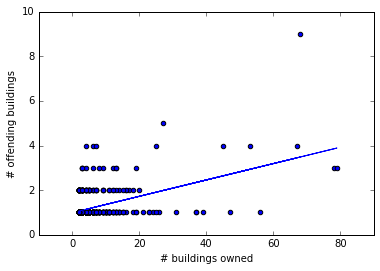

In [124]:
results = lr.predict(bad_joined["# buildings owned"].reshape(-1, 1))
ax = bad_joined.plot("# buildings owned", "# offending buildings", kind='scatter')
ax.plot(bad_joined['# buildings owned'], results)

In [126]:
(bad_joined['# offending buildings'] - results).sort_values(ascending=False).head(20)

OwnerName_x
SILVERSHORE PROPERTIE    5.516405
2166 DEAN LLC            3.018207
GIT LEB                  2.860681
EAST TREMONT BRONX HO    2.787423
JAIDYN REALTY HOUSING    2.750793
THE BANK OF NEW YORK     2.091466
146-150 TENTH ASSOCIA    1.897311
4640 BROADWAY LLC        1.897311
PENNSYLVANIA AVENUE A    1.897311
BEECH TERRACE PARTNER    1.860681
TROY INDUSTRIES, LLC     1.787423
GRAND CONCOURSE EASTH    1.714164
BSDC KINGS COVENANT H    1.677535
VED PARKASH              1.567647
UHAB HOUSING DEVELOPM    1.531017
HP GENESIS Y15 HOUSIN    1.531017
HPENY HOUSING DEVELOP    1.358879
CPE HOUSING DEVELOPME    1.311241
WELLS FARGO BANK, N.A    1.065845
NELSON, LANSFORD         0.933940
Name: # offending buildings, dtype: float64

Aaand there's Ved Parkash, a notorious slumlord - along with some of the other names we've been seeing in our other lists.

- https://therealdeal.com/new-research/topics/company/ved-parkash/

We also see Silvershore Properties, who has been in hot water (pun intended) very recently.
- https://www.dnainfo.com/new-york/20170613/greenpoint/silvershore-properties-landlord-tenant-mold-mice-rats-hpd-dob

## Remarks and how to use this analysis

### How to use
I'd probably take these values and look in gentrifying / contentious areas where we'd expect landlords to profit by residents out. I'm partial to the Bayesian ratio myself. But the regression does produce interesting results, by the ever-reliable "Google for news articles" metric.


### Who can use (city agencies)
HPD could use this.

### Future improvements
** Data Cleaning ** - I joined the data with a really sketchy maneuver (taking address + zipcode). I also see "PARKASH, VED" , "PARKASH VED", and "VED PARKASH" under "OwnerName" which all refer to the same slumlord. 

** Other features / complaints ** - this is just one dimension of ways landlords can push tenants out. We'd want to look at other dimensions.

** Incorporating rent stabilization data** - I'd like to include data about rent stabilized properties here. This is all properties, so we don't get a sense of what landlords might be incentivized to push out their tenants.